# Data Scientist Professional Practical Exam Submission

**Use this template to write up your summary for submission. Code in Python or R needs to be included.**


## 📝 Task List

Your written report should include both code, output and written text summaries of the following:
- Data Validation:   
  - Describe validation and cleaning steps for every column in the data 
- Exploratory Analysis:  
  - Include two different graphics showing single variables only to demonstrate the characteristics of data  
  - Include at least one graphic showing two or more variables to represent the relationship between features
  - Describe your findings
- Model Development
  - Include your reasons for selecting the models you use as well as a statement of the problem type
  - Code to fit the baseline and comparison models
- Model Evaluation
  - Describe the performance of the two models based on an appropriate metric
- Business Metrics
  - Define a way to compare your model performance to the business
  - Describe how your models perform using this approach
- Final summary including recommendations that the business should undertake

*Start writing report here..*

In [1]:
# Imports for following analysis
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split, KFold, cross_val_score, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
from sklearn.decomposition import PCA
from sklearn.metrics import classification_report

## Data Validation Intro / Column Notes
Below is a summary for each column with any accommodating clean-up detailed. A summary of the data clean-up steps will be listed following their completion in the subsequent cells and prior to the `Data Visualization` section.

* **recipe**: Numeric and unique values for each row. No cleaning required for unique identifier for recipe.
* **calories**: Numeric with 52 missing values. Cleaning required (Please see summary at bottom of section)
* **carbohydrate**: Numeric with 52 missing values. Cleaning required (Please see summary)
* **sugar**: Numeric with 52 missing values. Cleaning required (Please see summary)
* **protein**: Numeric with 52 missing values. Cleaning required (Please see summary)
* **category**: No null values. Category values included a second 'Chicken' value that was consolidated to the described possible grouping for the category. Category had 11 unique values but following cleaning has 10 matching the defined data field from the data schema provided.
* **servings**: No null values but values were type character and not numeric as defined in the data schema. Values altered to numeric to match provided data schema for field.
* **high_traffic**: Character field with only two observed values (High or null). Data description in project request notes that should recipe have high traffic it would be marked. As this column also has 373 null values, it can be generalized from the description that if a recipe was not intentionally marked than the traffic was not high. Null values have been labeled as Low traffic for analysis.

<br>

### Data Evaluation (Exploratory Analysis)
* Prior to visualizing some of our features and target values, we'll want to get a better grip on how our data currently looks and what steps should be taken prior to **Data Visualization** and **Model Fitting & Evaluation** 

In [2]:
recipe_site_traffic = pd.read_csv('recipe_site_traffic_2212.csv')
recipe_site_traffic.head()

,recipe,calories,carbohydrate,sugar,protein,category,servings,high_traffic
0,1,NaN,NaN,NaN,NaN,Pork,6,High
1,2,35.48,38.56,0.66,0.92,Potato,4,High
2,3,914.28,42.68,3.09,2.88,Breakfast,1,NaN
3,4,97.03,30.56,38.63,0.02,Beverages,4,High
4,5,27.05,1.85,0.80,0.53,Beverages,4,NaN


* Initially out of the box we can see some null values for features as well as for traffic, we can get an overall view of how many each column may have in our dataset

In [3]:
recipe_site_traffic.isna().sum()

recipe            0
calories         52
carbohydrate     52
sugar            52
protein          52
category          0
servings          0
high_traffic    373
dtype: int64

* From the provided Data Info with the project request, we can look under the hood to see if the data types match the provided info and see what if any adjustments are required

In [4]:
recipe_site_traffic.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 947 entries, 0 to 946
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   recipe        947 non-null    int64  
 1   calories      895 non-null    float64
 2   carbohydrate  895 non-null    float64
 3   sugar         895 non-null    float64
 4   protein       895 non-null    float64
 5   category      947 non-null    object 
 6   servings      947 non-null    object 
 7   high_traffic  574 non-null    object 
dtypes: float64(4), int64(1), object(3)
memory usage: 59.3+ KB


### Target Value (Traffic)
* With the highest overall null count of any of our columns, we need to dig in a bit more about what values the column may contain and if there is clear delineation between a recipe with `High Traffic` or one without

In [5]:
target_values_distinct_value_count = recipe_site_traffic['high_traffic'].nunique()
target_unique_values = recipe_site_traffic['high_traffic'].unique()
print(f"There are {target_values_distinct_value_count} distinct value(s) for the target traffic column, : ",
     f"unique values are : {target_unique_values}")

There are 1 distinct value(s) for the target traffic column, :  unique values are : ['High' nan]


#### Target Value (Traffic) Data Adjustments
* Based on the results above we can infer that if a recipe did not result in higher traffic to the site, it was marked `null`.
* Set **null** `high_traffic` values to 'Low' based on data description of field population along with single field unique value of 'High' as detailed above

In [6]:
# Set null high_traffic values to 'Low' based on data description of field population and single field unique value of 'High'
recipe_site_traffic.loc[recipe_site_traffic['high_traffic'].isna(), 'high_traffic'] = 'Low'
recipe_site_traffic['high_traffic'].value_counts(normalize=True)

High    0.606125
Low     0.393875
Name: high_traffic, dtype: float64

### Feature Nulls (Calories, Carbohydrates, Sugar, Protein) Evaluation
* We saw that the remaining null values were in these particular "feature" columns. 
* Need to see if the null values are shared for the recipe or simply individual values are missing across differente rows in the dataset
    * We can start by seeing if any of the features are null across the `row` axis 

In [7]:
# Any rows with a null value for the four columns indicating null values
null_feature_rows = recipe_site_traffic.loc[recipe_site_traffic[['calories', 'carbohydrate', 'sugar', 'protein']].isna().any(axis=1)]
display(null_feature_rows.head())
# Any column with null values appear to be shared across the row and not single missing values for a recipe
print("Our total number of rows for any missing data with our features (non-traffic column) is : {}".format(len(null_feature_rows)))

,recipe,calories,carbohydrate,sugar,protein,category,servings,high_traffic
0,1,NaN,NaN,NaN,NaN,Pork,6,High
23,24,NaN,NaN,NaN,NaN,Meat,2,Low
48,49,NaN,NaN,NaN,NaN,Chicken Breast,4,Low
82,83,NaN,NaN,NaN,NaN,Meat,4,High
89,90,NaN,NaN,NaN,NaN,Pork,6,High


Our total number of rows for any missing data with our features (non-traffic column) is : 52


* From the return of **total null rows** for any of the features being null, we can see that the `null` values is consistent throughout the entire recipe and not partial missing data for a recipe
* With the recipe not missing partial data but all values for these features, we'll removes these ~50 rows from the data set as our models further down the line does not accept null data and imputing missing data for an entire recipe with these continous features doesn't provide contextual evidence about what the potential value could be
    * For instance if only `protein` or another of the features was missing for a row we could make a better attempt at imputing the one or two missing pieces for a recipe but not knowing any of the continous values really leaves us in the dark for these recipes.

In [8]:
# Drop rows with missing values for features with missing values (all missing values for features share same rows as the above totalrows shows above) - Require at least 5 non-null values (discarding recipes with 4 missing values for features)
recipe_site_traffic.dropna(thresh=5, inplace=True)

####  Null Value Check
* Let's next validate that we have a matching `non-null` count for all of the columns in our dataset as well if any other adjustments are needed

In [9]:
# Validate dframe has 895 non-null values for all columns after column cleaning
recipe_site_traffic.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 895 entries, 1 to 946
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   recipe        895 non-null    int64  
 1   calories      895 non-null    float64
 2   carbohydrate  895 non-null    float64
 3   sugar         895 non-null    float64
 4   protein       895 non-null    float64
 5   category      895 non-null    object 
 6   servings      895 non-null    object 
 7   high_traffic  895 non-null    object 
dtypes: float64(4), int64(1), object(3)
memory usage: 62.9+ KB


#### Category Feature Evaluation
* This data point was detailed as having **10** possible groupings, let's validate that's the case

In [10]:
recipe_site_traffic['category'].nunique(), recipe_site_traffic['category'].unique()

(11,
 array(['Potato', 'Breakfast', 'Beverages', 'One Dish Meal',
        'Chicken Breast', 'Lunch/Snacks', 'Pork', 'Chicken', 'Vegetable',
        'Meat', 'Dessert'], dtype=object))

* We can see here there are two `Chicken` type values whereas the data info clearly details **10** possible groupings. 
    * We'll consolidate the values into the defined grouping of `Chicken` as provided in the data info 

In [11]:
# Category includes two values for Chicken when only one was listed in the Category
# Changing extra Chicken category to defined ten possible groupings which was 11 prior to clean-up
recipe_site_traffic.loc[recipe_site_traffic['category'] == 'Chicken Breast', 'category'] = 'Chicken'
# Validate value_counts for category is 10 categories : with a proportional look at that category
recipe_site_traffic['category'].value_counts(normalize=True)

Chicken          0.182123
Breakfast        0.118436
Beverages        0.102793
Potato           0.092737
Lunch/Snacks     0.091620
Vegetable        0.087151
Dessert          0.086034
Meat             0.082682
Pork             0.081564
One Dish Meal    0.074860
Name: category, dtype: float64

In [12]:
# Confirm 10 count for category and matching values
recipe_site_traffic['category'].nunique(), recipe_site_traffic['category'].unique()

assert recipe_site_traffic['category'].nunique() == 10

#### Servings Feature Evaluation
* `Servings` is defined as numeric in the provided data information but is a Character that requires cleaning, to standardize and use the value for subsequent exploration it has been transformed to numeric to match the data information as well as be eligible for model fitting further down the line

In [13]:
print(recipe_site_traffic['servings'].unique())
# Change str values to values that can be transformed to int
recipe_site_traffic.loc[recipe_site_traffic['servings'] == '4 as a snack', 'servings'] = '4'
recipe_site_traffic.loc[recipe_site_traffic['servings'] == '6 as a snack', 'servings'] = '6'
print(recipe_site_traffic['servings'].unique())

# Change dtype for servings to numeric per data schema provided
recipe_site_traffic['servings'] = recipe_site_traffic['servings'].astype('int64')

# assert dtype
assert recipe_site_traffic['servings'].dtype == 'int64' 

['4' '1' '2' '6' '4 as a snack' '6 as a snack']
['4' '1' '2' '6']


#### Non-Negative Feature Check
* As our features have been mutated and adjusted to fit the provided data information as well as initially prepared for future model usage, let's validate we don't have any negative values prior to model fitting
    * We can subset which columns we'd like to describe for this `continous` feature value check to look at values of interest here 

In [14]:
# Validate numeric variables are all non-negative
recipe_site_traffic.loc[:, ~recipe_site_traffic.columns.isin(['recipe', 'category', 'high_traffic'])].describe()

,calories,carbohydrate,sugar,protein,servings
count,895.000000,895.000000,895.000000,895.000000,895.000000
mean,435.939196,35.069676,9.046547,24.149296,3.458101
std,453.020997,43.949032,14.679176,36.369739,1.735979
min,0.140000,0.030000,0.010000,0.000000,1.000000
25%,110.430000,8.375000,1.690000,3.195000,2.000000
50%,288.550000,21.480000,4.550000,10.800000,4.000000
75%,597.650000,44.965000,9.800000,30.200000,4.000000
max,3633.160000,530.420000,148.750000,363.360000,6.000000


### Data Validation Summary
* `Calories`, `Carbohydrate`, `Sugar`, `Protein` columns had 52 missing values each. All missing values for the columns were shared across the same rows (see null feature rows for validation of discovery). With these features' missing data being shared across the whole row and not simply a missing partial piece of the recipe, they have been removed from subsequent analysis.
* `Category` contained initially 11 unique values that have been reduced to 10 per the possible groupings defined in the data schema. After consolidating two "Chicken" values from the column, the possible grouping/values for the column equal the defined ten groupings from the data schema.
* `Servings` was not a numeric column and was transformed to be a numeric value to match the schema.
* `high_traffic` contained either "null" or "high" values. Per the schema, values were marked only on the recipe shown should the traffic be **high**. As such, null values for the column (~400) have been marked 'Low' as they represent the inverse from the defined marking for the column and crucial data to try and predict which recipes will drive more traffic
* With our data now in a representative state to the provided data information as well as initially prepared for future model fitting and classification, we can take a further look and visualize our data.

## Exploratory Analysis / Data Visualization
### Target Feature - `Website Traffic`
* With an objective of predicting which recipes will lead to higher traffic, we can initially start by inspecting how many recipes resulted in **high traffic** against those which were not marked as having **high traffic**

* Let's also see how that looks proportionally for the recipes traffic before visualizing the total counts and proportional make-up

In [15]:
percent_series = recipe_site_traffic['high_traffic'].value_counts(normalize=True) * 100.
percent_series = percent_series.round(decimals=2)
percent_series

High    59.78
Low     40.22
Name: high_traffic, dtype: float64

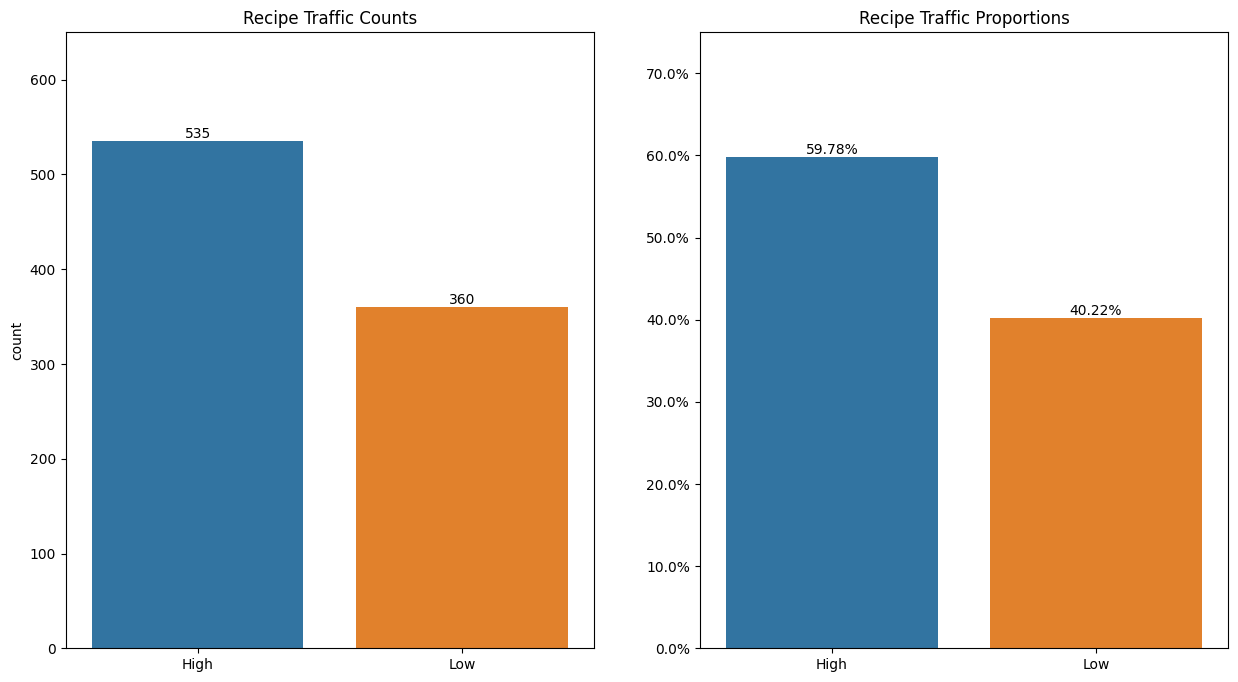

In [16]:
fig, axes = plt.subplots(1,2,figsize=(15,8))
sns.countplot(x=recipe_site_traffic['high_traffic'], ax=axes[0]).set(xlabel=None)
axes[0].set_ylim([0, 650])
axes[0].set_title('Recipe Traffic Counts')
axes[0].bar_label(axes[0].containers[0])
percent_series = recipe_site_traffic['high_traffic'].value_counts(normalize=True) * 100.
percent_series = percent_series.round(decimals=2)
axes[1] = sns.barplot(x=percent_series.index, y=percent_series.values)
axes[1].set_ylim([0, 75])
# We can use the labels argument to add a % sign for our labels
axes[1].bar_label(container=axes[1].containers[0], labels=["{}%".format(x) for x in percent_series.values])
# Set percent on y_axis for clear delineation (xticks() - returns up to 80 so will just chop that one off at the end)
ticks = [x for x in axes[1].get_yticks() if x < 80]
axes[1].set_yticks(ticks=ticks, labels=["{}%".format(x) for x in ticks])
axes[1].set_title('Recipe Traffic Proportions')
plt.show()

### Recipe Category Makeup
* With 10 unique categories/groupings our recipe could fall under, let's visualize the proportional make-up of `categories` 

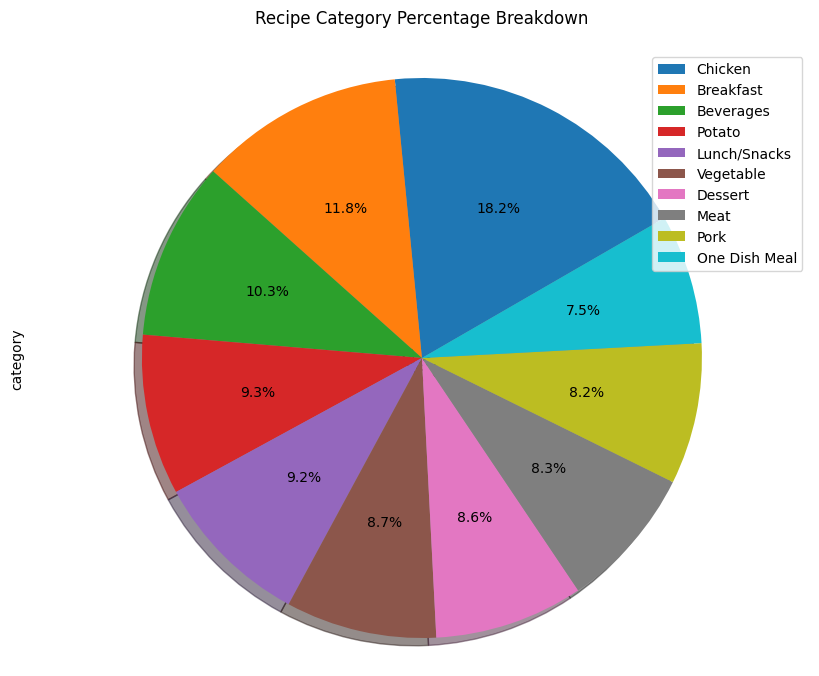

In [17]:
recipe_site_traffic['category'].value_counts().plot(kind='pie',
                                                   figsize=(10,8),
                                                   autopct='%1.1f%%',
                                                   startangle=30,
                                                   labels=None,
                                                   shadow=True)
plt.title('Recipe Category Percentage Breakdown', y=1.03, size=12)
plt.legend(labels=recipe_site_traffic['category'].value_counts().index, loc='upper right')
plt.axis('equal')
plt.show()

### Serving Size Distribution
* For a last peek at a single feature in our dataset, we can see if the various serving sizes have a similar proportional makeup from our data

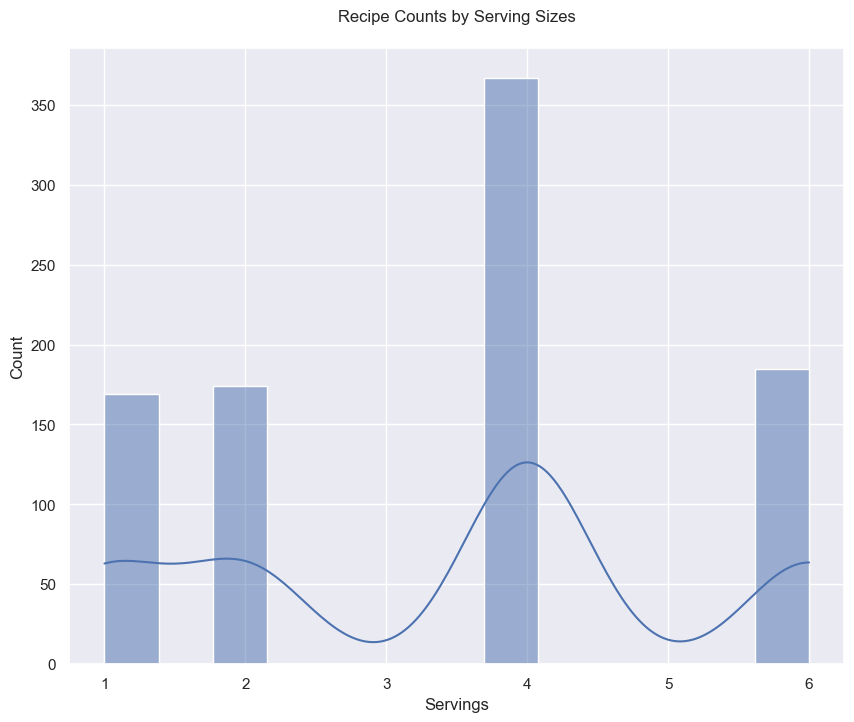

In [18]:
sns.set(rc={'figure.figsize': (10, 8)})
sns.histplot(x=recipe_site_traffic['servings'], kde=True)
plt.xlabel('Servings', y=1.03)
plt.title('Recipe Counts by Serving Sizes', y=1.03)
plt.show()

### Continous (Calories, Carbs, Sugar, Protein) Ranges - Distribution
* We can see how the distributions for these features to see how our recipes range over the categories

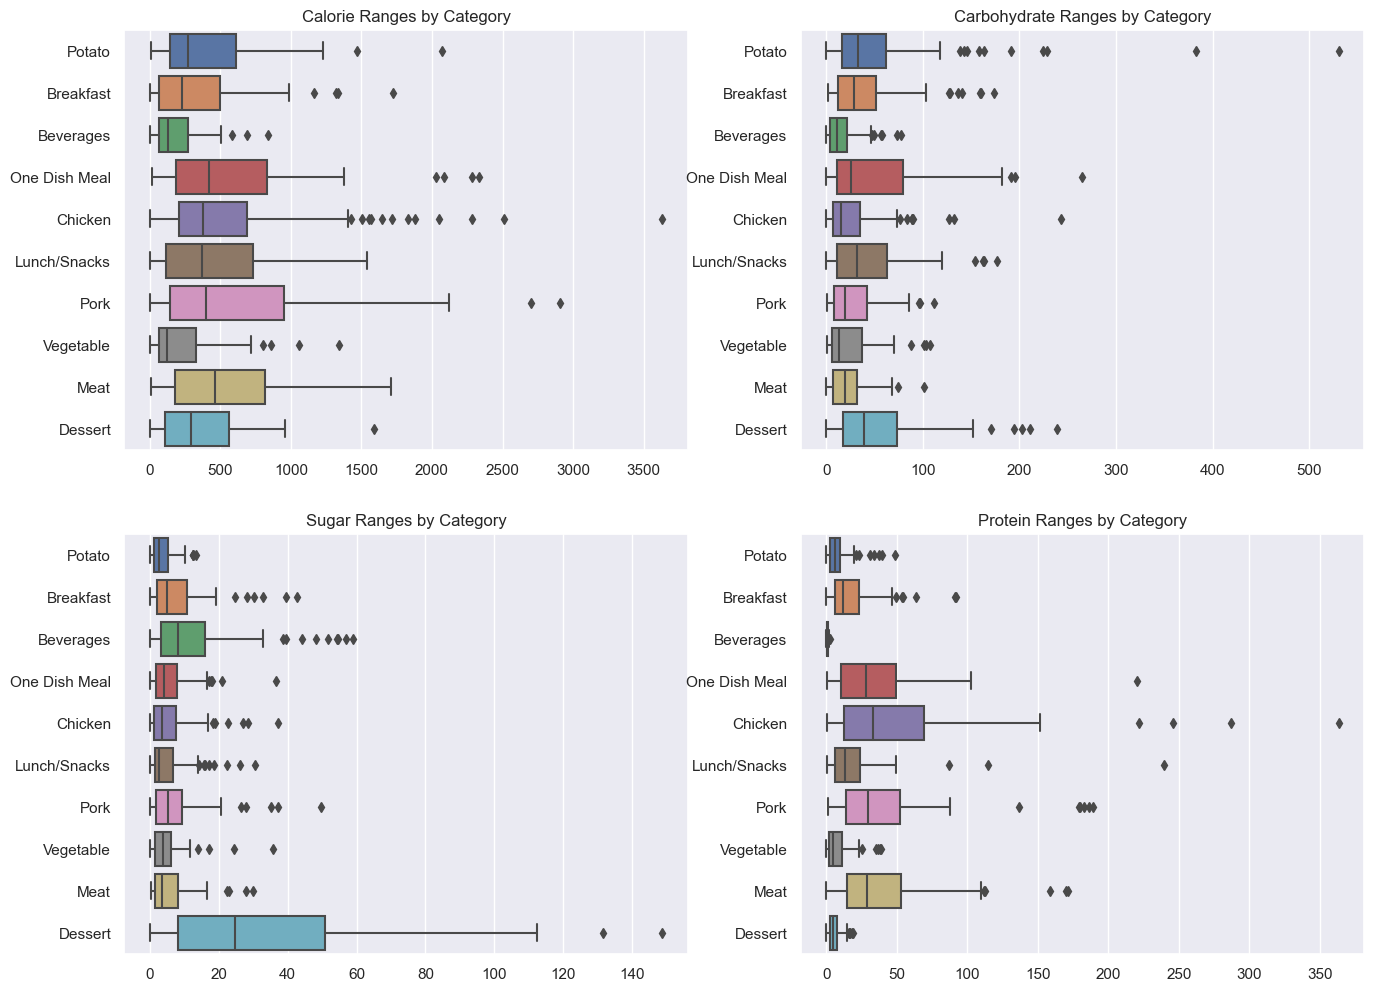

In [19]:
fig, axes = plt.subplots(2,2,figsize=(16,12))
sns.boxplot(x='calories', y='category', ax=axes[0,0], data=recipe_site_traffic).set(title='Calorie Ranges by Category', xlabel=None, ylabel=None)
sns.boxplot(x='carbohydrate', y='category', ax=axes[0,1], data=recipe_site_traffic).set(title='Carbohydrate Ranges by Category', xlabel=None, ylabel=None)
sns.boxplot(x='sugar', y='category', ax=axes[1,0], data=recipe_site_traffic).set(title='Sugar Ranges by Category', xlabel=None, ylabel=None)
sns.boxplot(x='protein', y='category',  ax=axes[1,1], data=recipe_site_traffic).set(title='Protein Ranges by Category', xlabel=None, ylabel=None)
plt.show()

### Traffic By Category

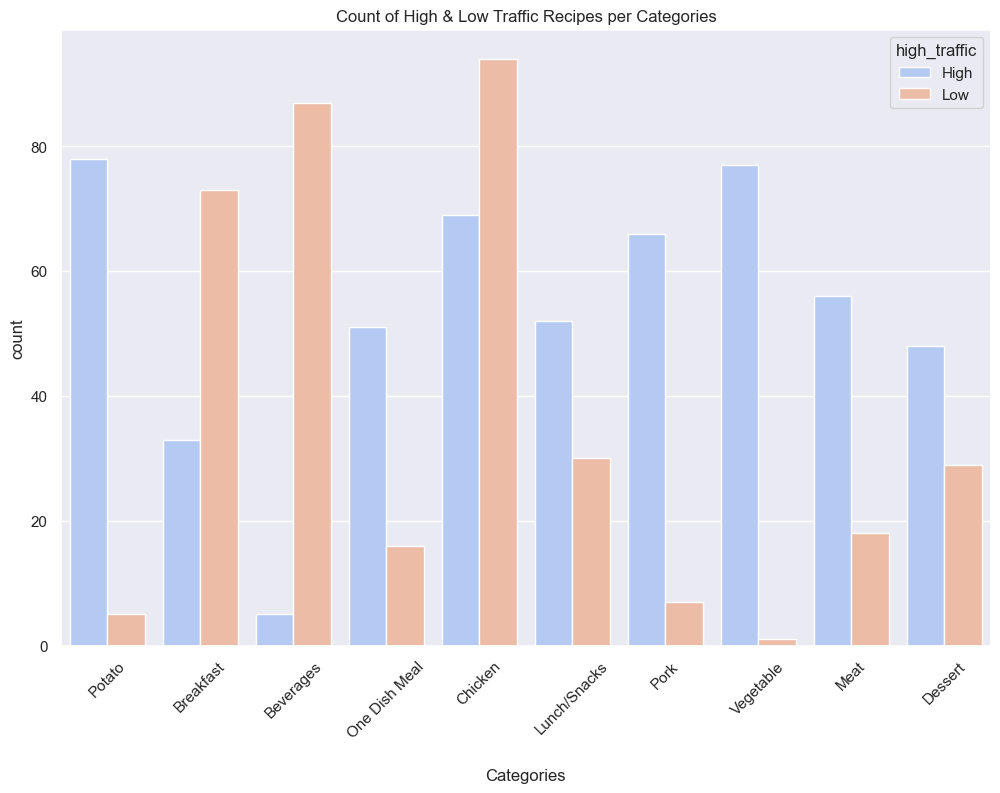

In [20]:
plt.figure(figsize=(12, 8))
sns.countplot(x='category', data=recipe_site_traffic, palette='coolwarm', hue='high_traffic')
plt.title("Count of High & Low Traffic Recipes per Categories")
plt.xticks(rotation=45)
plt.xlabel('Categories', labelpad=20)
plt.show()

* Certainly see some interesting relationships here and notably the ratios for `Potato`, `Beverages`, `Pork` and `Vegetable` in regards to their respective traffic counts 

### Recipes Category By Servings & Traffic
* Lastly we can see if certain `serving` sizes for our different categories influenced if the particular recipe resulted in high traffic

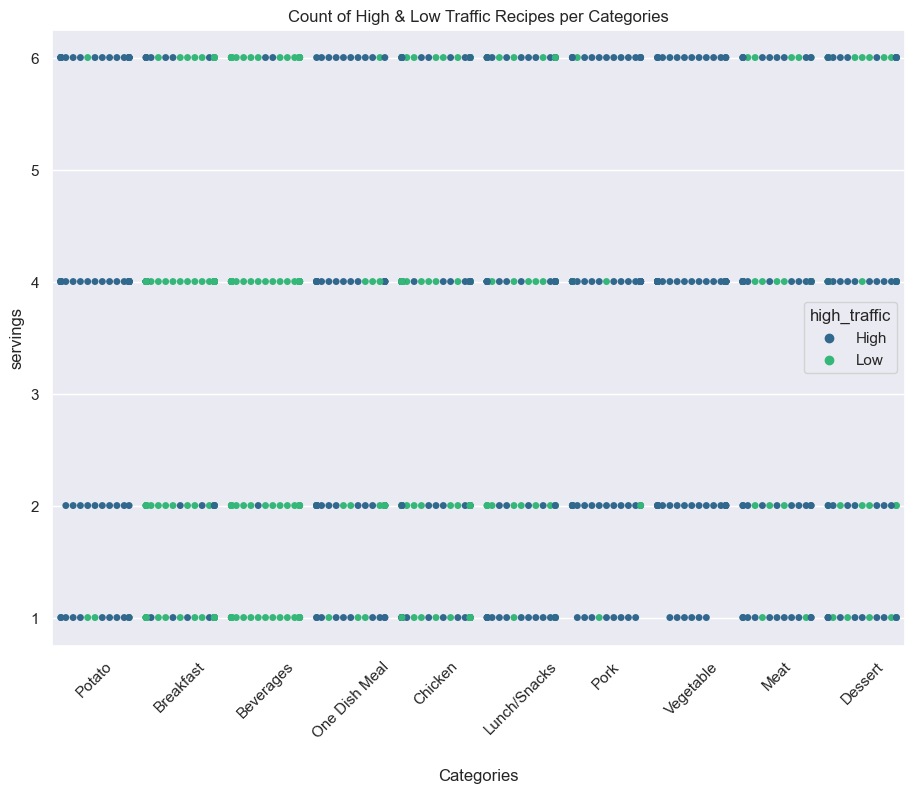

In [21]:
plt.figure(figsize=(11, 8))
sns.swarmplot(x='category', y='servings', data=recipe_site_traffic, 
              hue='high_traffic', palette='viridis')
plt.title("Count of High & Low Traffic Recipes per Categories")
plt.xticks(rotation=45)
plt.xlabel('Categories', labelpad=20)
plt.show()

* In conjunction with the bar charts showing the overall counts (raw numbers below for high/low traffic by category) the  scatterplot/swarmplot by serving size visual above gives us a good indication if any distinct `serving size(s)` resulted in higher or lower traffic for the 10 categories.
    * Ex :  Our highest category `Chicken` has a negative ratio (more low traffic recipes to high traffic recipes) if the recipe calls for 2 or 4 servings but has a more or less equal ratio if the recipe calls for 1 or 6 servings

In [22]:
recipe_cat_serving_traffic_counts = recipe_site_traffic.groupby(['category', 'servings', 'high_traffic'])['recipe'].count()
df_servings_counts = recipe_cat_serving_traffic_counts.unstack(level=1)
df_servings_counts

servings                       1     2     4     6
category      high_traffic                        
Beverages     High           1.0   1.0   1.0   2.0
              Low           19.0  16.0  33.0  19.0
Breakfast     High           9.0   7.0   9.0   8.0
              Low           17.0  14.0  32.0  10.0
Chicken       High          18.0  11.0  25.0  15.0
              Low           17.0  18.0  44.0  15.0
Dessert       High          10.0   7.0  19.0  12.0
              Low            6.0   6.0   9.0   8.0
Lunch/Snacks  High          15.0   6.0  19.0  12.0
              Low            2.0   9.0  12.0   7.0
Meat          High          11.0  10.0  26.0   9.0
              Low            2.0   3.0   8.0   5.0
One Dish Meal High          10.0  14.0  17.0  10.0
              Low            3.0   8.0   4.0   1.0
Pork          High           8.0  14.0  30.0  14.0
              Low            1.0   2.0   3.0   1.0
Potato        High          11.0  10.0  35.0  22.0
              Low            3.0   NaN   1.0   1.0
Vegetable     High           6.0  18.0  39.0  14.0
              Low            NaN   NaN   1.0   NaN

### Data Visualizations Quick Summary
1. Target Variable `High_Traffic`
    * Of our nearly ~900 recipes evaluated, nearly **60%** of all recipes resulted in `High_Traffic`.
2. Recipe `Category` Proportions
    * Outside of the `Chicken` category which accounts for ~18% of all recipes in our data, most of our categories we can see in a range of ~8-11% percent to provide equitable representations of the 10 categories in our overall recipe ccounts
3. `Servings` Distributions
    * We can see that recipes with `4` serving sizes was the dominant serving size for our overall recipes counts with the other respective sizes (1, 2, 6) having nearly equal counts
4. Recipe Nutritional Values Distribution by `Category`
    * We see fairly tight distributions for most of our `categories` with an emphasis on which categories had recipes with the most amount of outliers. 
5. `Traffic` By Category
    *  Here we can get an estimate and idea on how the categories performed in registering high traffic or not and can see some striking disparities between the categories.
    *  Ex : Beverages and Breakfast Recipes performed very poorly in registering high traffic
6. `Traffic` By Category and Serving Size
    * Our last visualization helps us visualize if different serving sizes by the recipes' category resulted in any difference for traffic

<br>

## Classification Models Generation & Metric Selection, Principal Component Analysis & Data Model Preprocessing
* In predicting whether our recipe registered `high_traffic` or not, we'll use a host of classification type models to see where we can achieve the highest accuracy.
* Prior to fitting a model, we'll see if an `elbow` point can be found for principal component analysis to see if a certain number of features can explain the variance for our target variable `traffic`
    * As the # of features is not too high here we'll also see if the accuracy is within range of the defined 80% goal as detailed in the project request.
     
### Scoring Tools : Classifaction Report and Cross_Val_Score
* In order to evaluate the classification estimator "model" to use, we'll initially use the `mean_accuracy` score value returned from `cross_val_score` which calls the default score method for the model passed. Each model returns this mean accuracy value (from  which will be the model's ability to predict the labels (recipe traffic) based on the folds that it was trained with and test on.
    * Using this method allows use to Kfolds to split the provided training data into various train/test splits before predicting the mean accuracy and allow us to fit two of the four classification models we'll be testing
* After visualizing the model's accuracy from cross_val_score we can look into the `classifciation report` to look at the model's `F1 Score` which will provide a harmonic mean of precision and recall
    * Precision - Percentage of correct positive predictions relative to total positive predictions
    * Recall - Percentage of correct positive prediction relative to total actual positives
    * As the F1 Score balances both allowing us to use that as the final metric to evaluate the models with a score closer to 1 representing the better and more accurate model!



### Classification Models 
* For classifying of type recipes, we can initially evaluate which of a few classification models (**KNN**, **DecisionTree**, **Logistic Regression** & **SVM**) will provide the highest accuracy for our predictions using each model's mean_accuracy score 

<br>

### Data Preparation for Model Selection
* However, we need to prepare the data for the sklearn library first as well as normalize our continous features (Calories, Carbs, Sugar, & Protein) as classification models can be significantly impacted by extreme values in our data
* Steps
    * Categorize **target** `Traffic` value as a boolean/numeric value 
        * 0 - Low_Traffic
        * 1 - High_Traffic
    * Set Boolean/Numeric value for `category` feature value to be accepted by model
        * Recipe will be classified as 1 with the appropriate category with all other `category` types marked as 0 so as to classify per the model's requirement
    * Normalize Continous Data Features
        * The Continous features will be normalized using `StandardScaler` and combined with the categorical features for the different food categories 

In [23]:
# Make copy instance of recipe_site
recipe_model_df = recipe_site_traffic.copy()

# Adjust high_traffic column to binary
recipe_model_df.replace({'high_traffic': {'High':1, 'Low': 0}}, inplace=True)

# Quick Look at Replaced Target Values to Binary 
display(recipe_model_df.head(2))

# Replace categorical features - drop first category value (Creating 9 Values for Binary Categorical Data)
recipe_model_sci_kit = pd.get_dummies(recipe_model_df, drop_first=True)

# Quick look 
display(recipe_model_sci_kit.head(2))

,recipe,calories,carbohydrate,sugar,protein,category,servings,high_traffic
1,2,35.48,38.56,0.66,0.92,Potato,4,1
2,3,914.28,42.68,3.09,2.88,Breakfast,1,0


,recipe,calories,carbohydrate,sugar,protein,servings,high_traffic,category_Breakfast,category_Chicken,category_Dessert,category_Lunch/Snacks,category_Meat,category_One Dish Meal,category_Pork,category_Potato,category_Vegetable
1,2,35.48,38.56,0.66,0.92,4,1,0,0,0,0,0,0,0,1,0
2,3,914.28,42.68,3.09,2.88,1,0,1,0,0,0,0,0,0,0,0


In [24]:
# Create feature values : drop target and recipe index columns
X = recipe_model_sci_kit.drop(['recipe', 'high_traffic'], axis=1).values
# Get Values for High_Traffic target value
y = recipe_model_sci_kit['high_traffic'].values 

# Separate X features from categorical/continous - Will scale continous then concat values to pass to train_test_split
X_continous = pd.DataFrame(X[:, :5])
print(X_continous[:1]) # look at our first values prior to normalization
X_category = pd.DataFrame(X[:, 5:])

# Scale Features (Non-Dummies Categorical)
scaler = StandardScaler()
X_scaled = pd.DataFrame(scaler.fit_transform(X_continous))

# Concatenate scaled continous features, with categorical "Recipe Category" binary values
X_scaled = pd.concat([X_scaled, X_category], axis=1).values
print(X_scaled[:5, 1]) # look at our first values following normalization

# Assert X and X_scaled have same rows and columns as (originally seaprated features : X)
assert X.shape == X_scaled.shape

       0      1     2     3    4
0  35.48  38.56  0.66  0.92  4.0
[ 0.07946194  0.17325931 -0.10266887 -0.75629083 -0.71963701]


* Our features have now been scaled for the cotinous values and concatenated with the categorical values for the food's category and traffic designation
* Also the assertion confirms that our features shape prior to being scaled is the same shape after the work perfomed above (as no assertion is raised we can be assure they are the same)

<br>

### PCA Feature Reduction
* Following normalizing and encoding our data for model classification, we can visualize to what degree the number of features may be required to explain the variance in our target `high_traffic`.
* Let's see if we can reduce dimenstionality and find an `elbow` point in which we may be able to explain the variance.
* Similar to fitting a model we'll need to split our data first

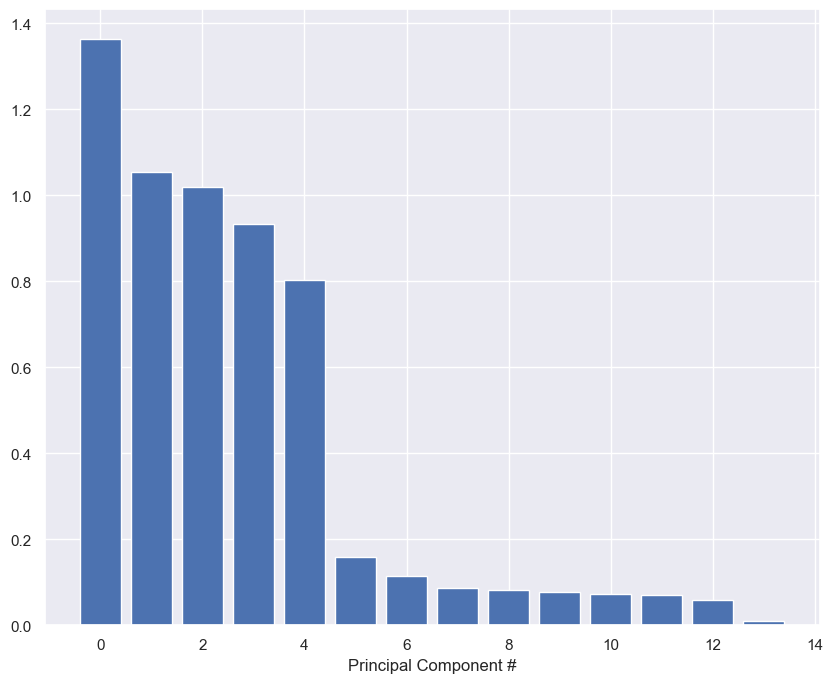

In [25]:
# Create Test_Train_Split for PCA and 
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.25, 
                                                    random_state=21)
# look for explained vairance
pca = PCA()
pca.fit(X_train)
exp_variance = pca.explained_variance_

# Look for elbow point
fig, ax = plt.subplots()
ax.bar(range(pca.n_components_), exp_variance)
ax.set_xlabel('Principal Component #')
plt.show()

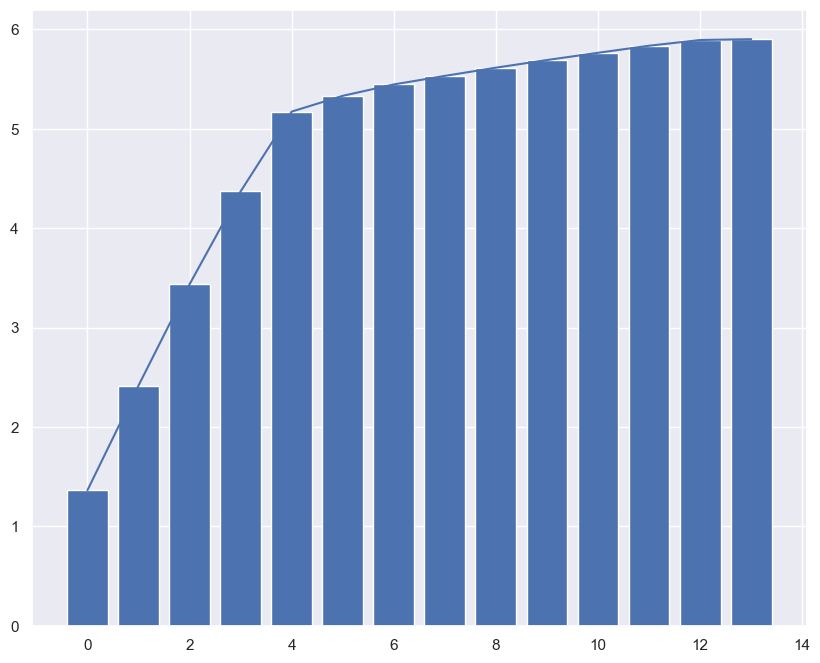

In [26]:
# Cumulative sum of variance explained by features
cum_exp_variance = np.cumsum(exp_variance)

# Plot the cumulative explained variance
fig, ax = plt.subplots()
ax.bar(range(pca.n_components_), cum_exp_variance)
ax.plot(cum_exp_variance)
plt.show()

* By the fith bar (index 4) we would hit our elbow point in our features explaining variance, therefore we can use `5` components to perform PCA and reduce the dimensionality

In [27]:
# Perform PCA with chosen number of components
pca = PCA(n_components=5, random_state=42)

# Fit and transform the scaled training feautrs
train_pca = pca.fit_transform(X_train)

# Transform method for test_features
test_pca = pca.transform(X_test)

In [28]:
train_pca[:5], test_pca[:5]

(array([[ 0.36455213, -0.39462191, -0.90225753, -0.88656547, -0.03908332],
        [-0.55424259, -1.28278977,  0.90169239,  0.23256045,  0.6819361 ],
        [-0.65258003, -0.4205489 ,  0.04037587,  0.11424983,  0.93228723],
        [ 1.25250031,  1.94517019, -1.259081  ,  2.76064781,  0.2532637 ],
        [-0.01238968,  0.27905333, -1.50522137, -0.39573439, -0.37863681]]),
 array([[ 0.77874673,  0.00718356, -0.68275738, -0.81664659,  0.02763966],
        [ 0.34305398,  0.02048754, -0.2443855 ,  1.18679931,  0.22988158],
        [-0.68711527,  0.93147981, -0.73867451,  0.41135668,  1.8593426 ],
        [-1.77009873,  1.10600142, -0.7488739 , -0.73511353,  3.20878867],
        [ 0.50339342,  1.6357015 ,  0.17985193,  2.31672641, -0.62235512]]))

* As we can see the PCA has ignored the other features from our original train/test set and included the features only with the highest variance

<br>

### Visualize Classification Model Performance
* We'll use KFolds to evaluate which of our defined potential classification models has the most accuracy over the various folds the model is fit and tested over 
* `Cross_Val_Score` returns an array of scores from each estimator "model" for each run of cross validation and will give us a good idea on which model(s) to fit.
    * The cross validation will split the provided training data by K folds so as to perform an iterative test/train scoring for the model's accuracy 

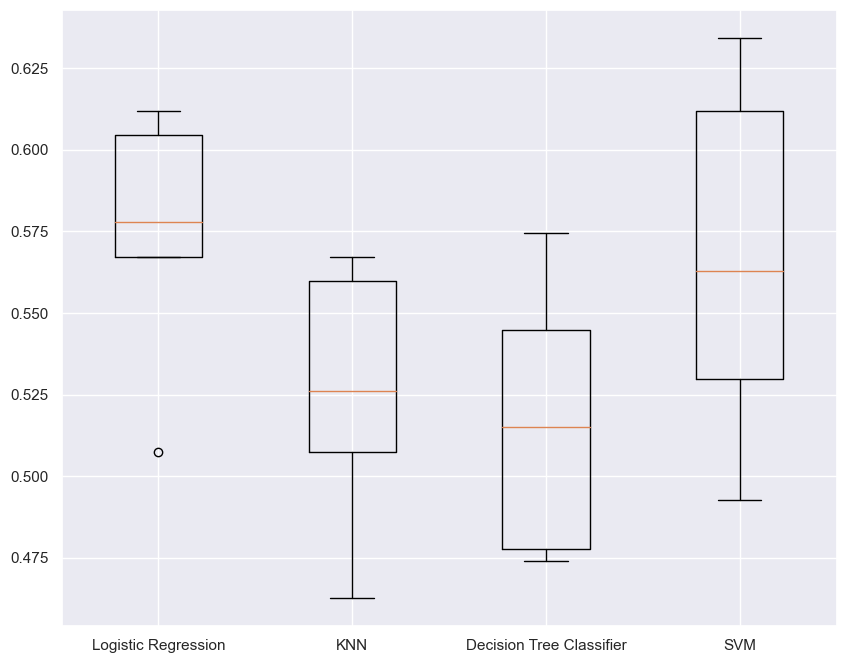

In [29]:
# Create models dictionary
models = {"Logistic Regression": LogisticRegression(), "KNN": KNeighborsClassifier(), 
          "Decision Tree Classifier": DecisionTreeClassifier(), "SVM": SVC()}
results = []

# Loop through the models' values
for model in models.values():
  
  # Instantiate a KFold object
  kf = KFold(n_splits=5, random_state=12, shuffle=True)
  
  # Perform cross-validation (split provided training into K folds to compute mean accuracy for prediction accuracy)
  cv_results = cross_val_score(model, train_pca, y_train, cv=kf)
  results.append(cv_results)

# Visualization of Classification Models Accuracy
plt.boxplot(results, labels=models.keys())
plt.show()

* `Logistic Regression` & `SVM` appears to have the highest scores from the `cross_validation` performed over 5 folds with the provided training data being split into 5 training/testing splits and returning a mean accuracy score for the model's prediction over each fold's assigned test data
    * However, the accuracy for the models is not very close to the target  so we may need to fit our model with the features eliminated with the `PCA`. 
    * We'll see if the two models below have a higher accuracy  after hyperparameter tuning for the model declaration

## Model Development

### Logistic Regression Model Fit & Hyperparameter Tuning

In [30]:
# Declare model
steps = [('log_reg', LogisticRegression())]

# Set up pipeline
pipeline = Pipeline(steps)
# Set params for GridSearchObject
params = {"log_reg__solver": ["newton-cg", "saga", "lbfgs"],
         "log_reg__C": np.linspace(0.001, 1.0, 20),
         "log_reg__penalty": ['l1', 'l2', 'elasticnet'],
         "log_reg__fit_intercept": [True, False]
         }

# Create the GridSearchCV object
tuning = GridSearchCV(pipeline, param_grid=params, cv=5)
tuning.fit(train_pca, y_train)
y_pred = tuning.predict(test_pca)

# Compute and print performance :  best parameters and compute and print the test set accuracy score for the grid search object.
print("Tuned Logistic Regression Parameters: {}, Accuracy: {}".format(tuning.best_params_, tuning.score(test_pca, y_test)))

Tuned Logistic Regression Parameters: {'log_reg__C': 0.2113157894736842, 'log_reg__fit_intercept': True, 'log_reg__penalty': 'l2', 'log_reg__solver': 'newton-cg'}, Accuracy: 0.6875


* A 5 feature fit Logisitc Regression Model returned a nearly 69% accuracy in predicting if a recipe would generate in high_traffic or not

### Support Vector Model Fit & Hyperparameter Tuning

In [31]:
# Declare model
steps = [('svm', SVC())]

# Set up pipeline
pipeline = Pipeline(steps)
# Set params for GridSearchObject
params = {"svm__C": np.linspace(0.001, 1.0, 20),
         "svm__gamma": ['scale', 'auto'],
         "svm__probability": [True, False],
         "svm__decision_function_shape": ['ovo', 'ovr']
         }

# Create the GridSearchCV object
tuning = GridSearchCV(pipeline, param_grid=params, cv=5)
tuning.fit(train_pca, y_train)
y_pred = tuning.predict(test_pca)

# Compute and print performance :  best parameters and compute and print the test set accuracy score for the grid search object.
print("Tuned Logistic Regression Parameters: {}, Accuracy: {}".format(tuning.best_params_, tuning.score(test_pca, y_test)))

Tuned Logistic Regression Parameters: {'svm__C': 0.47421052631578947, 'svm__decision_function_shape': 'ovo', 'svm__gamma': 'auto', 'svm__probability': True}, Accuracy: 0.6741071428571429


* A 5 feature fit SVM Model returned around a 67.4% accuracy in predicting if a recipe would generate in high_traffic or not

<br>

### PCA Model Fit Analysis
* Although **5** Features appear to account for a majority of the variance, our Model Accuracies above aren't as close to the threshold we are looking for with the accuracy of each model in the upper to high 60s after being tuned with the best parameters.
* Revisiting the Explained variance (see figure from PCA above), we can see that despite a notable elbow point at our 6th feature (start of the category classifications), we see that the cumulative variance from the features after the elbow point could have a notable level of explained variance. The last feature is the only variable that looks like it can be omitted as its' variance is hardly visible
* As such, we'll create a new set of PCA features to try and improve model accuracy including more features

### Model Fit & Evaluation for higher PCA Features
* We'll follow the same steps above in creating new PCA features to assess model accuracy from the original scaled features to see if we can compute a higher accuracy

In [32]:
# Perform PCA with higher number of components
pca = PCA(n_components=13, random_state=42)

# Fit and transform the scaled training features from originally split normalized data
train_pca = pca.fit_transform(X_train)

# Transform method for test_features
test_pca = pca.transform(X_test)

### New Model Fits 
* We'll use the two models (LogReg & SVM) that showed the most promise in our first PCA model classification model fits with the newly created **test** and **train** pca variables above 

In [33]:
# Declare model
steps = [('log_reg', LogisticRegression())]

# Set up pipeline
pipeline = Pipeline(steps)
# Set params for GridSearchObject
params = {"log_reg__solver": ["newton-cg", "saga", "lbfgs"],
         "log_reg__C": np.linspace(0.001, 1.0, 20),
         "log_reg__penalty": ['l1', 'l2', 'elasticnet'],
         "log_reg__fit_intercept": [True, False]
         }

# Create the GridSearchCV object
tuning = GridSearchCV(pipeline, param_grid=params, cv=5)
tuning.fit(train_pca, y_train)
y_pred = tuning.predict(test_pca)

# Compute and print performance :  best parameters and compute and print the test set accuracy score for the grid search object.
print("Tuned Logistic Regression Parameters: {}, Accuracy: {}".format(tuning.best_params_, tuning.score(test_pca, y_test)))
# Classification Report for Further Model Metric Evaluation
log_reg_classification_report = classification_report(y_test, y_pred)
print(log_reg_classification_report)

Tuned Logistic Regression Parameters: {'log_reg__C': 0.05357894736842105, 'log_reg__fit_intercept': False, 'log_reg__penalty': 'l2', 'log_reg__solver': 'newton-cg'}, Accuracy: 0.7410714285714286
              precision    recall  f1-score   support

           0       0.59      0.70      0.64        73
           1       0.84      0.76      0.80       151

    accuracy                           0.74       224
   macro avg       0.71      0.73      0.72       224
weighted avg       0.76      0.74      0.75       224



In [34]:
# Declare model
steps = [('svm', SVC())]

# Set up pipeline
pipeline = Pipeline(steps)
# Set params for GridSearchObject
params = {"svm__C": np.linspace(0.001, 1.0, 20),
         "svm__gamma": ['scale', 'auto'],
         "svm__probability": [True, False],
         "svm__decision_function_shape": ['ovo', 'ovr']
         }

# Create the GridSearchCV object
tuning = GridSearchCV(pipeline, param_grid=params, cv=5)
tuning.fit(train_pca, y_train)
y_pred = tuning.predict(test_pca)

# Compute and print performance :  best parameters and compute and print the test set accuracy score for the grid search object.
print("Tuned SVC Parameters: {}, Accuracy: {}".format(tuning.best_params_, tuning.score(test_pca, y_test)))
# Classification report for Further Model Metric Evaluation
svm_classification_report = classification_report(y_test, y_pred)
print(svm_classification_report)

Tuned SVC Parameters: {'svm__C': 0.9474210526315789, 'svm__decision_function_shape': 'ovo', 'svm__gamma': 'scale', 'svm__probability': True}, Accuracy: 0.75
              precision    recall  f1-score   support

           0       0.62      0.62      0.62        73
           1       0.81      0.81      0.81       151

    accuracy                           0.75       224
   macro avg       0.72      0.72      0.72       224
weighted avg       0.75      0.75      0.75       224



## Final Model Classification Report - Model Evaluation & Metric Assessment
* The Classification report for each model provides `precision`, `recall` and `F1 score` 
    * `Precision` - Percentage of correct positive prediction relative to total positive predictions
    * `Recall` - Percentage of correct positive predictions relative to total actual positives
    * `F1 Score` - Weighted harmonic mean of precision and recall, the closer to 1 the better the model!
    * `Support` - These values show how many recipes belonged to each class (Low_Traffic - 0 & High_Traffic - 1)  

### Logistic Regression Model Performance
* `Precision` : Out of all the recipes the model predicted would result in high_traffic, **84%** did!
* `Recall` : Out of all the recipes that actually did result in high_traffic, the model predicted this outcome correctly **76%** of the time
* `F1` : Our harmonic mean accuracy of **74%** matches the `mean_accuracy` from the default scoring of our classification model

### SVM Regression Model Performance
* `Precision` : Out of all the recipes the model predicted would result in high_traffic, **81%** did!
* `Recall` : Out of all the recipes that actually did result in high_traffic, the model predicted this outcome correctly **81%** of the time
* `F1` : Our harmonic mean accuracy of **75%** matches the `mean_accuracy` from the default scoring of our classification model

## Business Recommendation
To assist our product team in predicting recipes which will result in **high_traffic**, we can deploy the **SVM** classification algorithm which had the highest model accuracy and weighted F-1 Score from the classification report metrics above. The desired goal of 80% accuracy or model's predictive ability in predicting high or low_traffic is within range with the provided data with likely model improvements and further data collection assisting in improving overall accuracy.

### Business Current Recipe Selection & Model Usage
To help evaluate the model's performance on generated subscriptions, **A/B** testing could be performed on comparing newly generated subscriptions with the current selection of recipes by the product team against recipe selection with the deployment of the SVM model.

### Model Improvement & Data Collection Efforsts
To improve the model and it's prediction accuracy closer to the requested percentage (80%), the following items could be considered
* Data Completeness
    * As the continous features (items such as Carbs, Sugars, etc - numeric and non categoric values about recipe nutritional values) were key in the `PCA` analysis and accounted for the most explained variance for our target variable of `high_traffic`, revisiting the recipes with null values for all these features could likely lead to a higher model weighted accuracy in predicting `high_traffic` recipes
* More Recipes that resulted in `low_traffic`
    * The Classification report score for each model showed a greater ability to predict recipes with `high_traffic` but struggled with the `low_traffic` classification predictions in both the precision and recall metrics 
    * As the proportion of total recipes from the dataset showed a 6 to 10 ratio for high_traffic recipes, recipes with `low_traffic` would be instructive in helping improve overall model accuracy and in particular with predicting correctly recipes that would result in `low_traffic` and bump up the overall F1 score.

## ✅ When you have finished...
-  Publish your Workspace using the option on the left
-  Check the published version of your report:
	-  Can you see everything you want us to grade?
    -  Are all the graphics visible?
-  Review the grading rubric. Have you included everything that will be graded?
-  Head back to the [Certification Dashboard](https://app.datacamp.com/certification) to submit your practical exam report and record your presentation